# Iris Flower Dataset

This document presents the production of explanations using MeLIME method for a Random Forest (RF) model trained on the Iris Flower Dataset (regarding the dataset, please see https://en.wikipedia.org/wiki/Iris_flower_data_set). The produced explanations are compared with LIME methodology.

This notebook compares the LIME with MeLIME results. You will need to have LIME installed with you would like to obtain LIME explanations, you can do that by:
> pip install lime

In [1]:
import sys,os
sys.path.append('..')

import pickle
import numpy as np
from sklearn import datasets
import sklearn.ensemble
from sklearn import metrics
from matplotlib import pyplot as plt

import lime.lime_tabular
from melime.explainers.explainer import Explainer
from melime.generators.kde_gen import KDEGen
from melime.generators.kdepca_gen import KDEPCAGen
from melime.explainers.visualizations.plot_importance import ExplainGraph
from sklearn import tree

# Load Data 

In [2]:
data = datasets.load_iris()
x_all = data.data
y_all = data.target
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    x_all, y_all, train_size=0.80, random_state=123)

# Training a RF Model

In [3]:
rf = sklearn.ensemble.RandomForestClassifier()
filename = 'rf_model_iris.bin'
if os.path.exists(filename):
    rf = pickle.load(open(filename, 'rb'))
else:
    rf.fit(x_train, y_train)
    pickle.dump(rf, open(filename, 'wb'))

y_train_pred = rf.predict(x_train)
y_test_pred = rf.predict(x_test)
y_all_pred = rf.predict(data.data)

In [4]:
print('Acurancy_score: ', metrics.accuracy_score(y_test, y_test_pred))
print('Random Forest Mean Square Error: ', np.mean((y_test_pred - y_test) ** 2))
print('MSError when predicting the mean: ', np.mean((y_train.mean() - y_test) ** 2))

Acurancy_score:  0.9333333333333333
Random Forest Mean Square Error:  0.06666666666666667
MSError when predicting the mean:  0.8024999999999999


# Interpretation and Explanation

In [5]:
from melime.explainers.visualizations.visualization import GridPlot

In [6]:
i = 3
x_explain = x_test[i]
x_explain = np.array([[6.0, 3., 5, 1.5]])
y_explain = 1
x_explain,y_explain, rf.predict(x_explain.reshape(1, -1))

(array([[6. , 3. , 5. , 1.5]]), 1, array([1]))

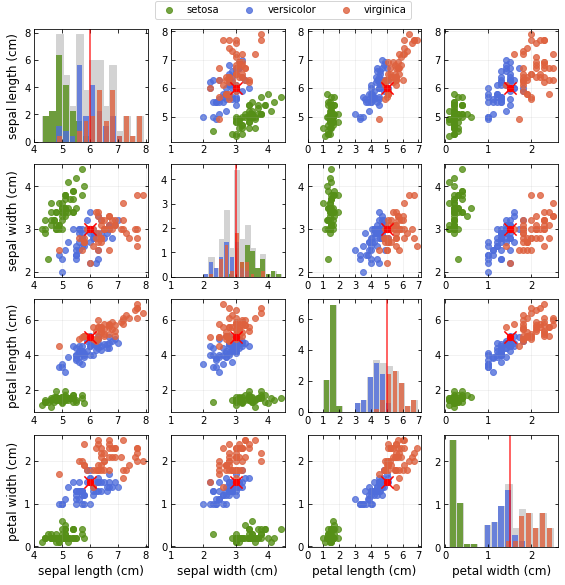

In [8]:
# Code to plot the data and the instance that we want to explain.
x = data.data
y = y_all_pred
y_names = {i:name for i, name in enumerate(data.target_names)}
colors = ['#558F17', '#4F6DDB', '#DE613E']
axis, _ = GridPlot.plot(
    x=x, x_cols_name=data.feature_names, y=y, y_names=y_names, colors=colors, alpha=0.8)
GridPlot.plot_instance(x_explain[0], axis)
for ax in axis.ravel():
    start, end = ax.get_xlim()
    stepsize = 1
    ax.xaxis.set_ticks(np.arange(int(start), end, stepsize))
plt.savefig('grid_model_predictions.pdf')

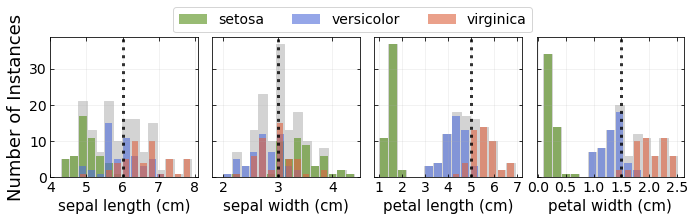

In [9]:
colors = ['#558F17', '#4F6DDB', '#DE613E']
fig, axis = GridPlot.plot_histogram(
    x=x, x_cols_name=data.feature_names, y=y, y_names=y_names, colors=colors, alpha=0.6)
for i, ax in enumerate(axis):
    ax.axvline(x_explain[0][i], c="black", lw=3.0, linestyle=':', alpha=0.8)   
    start, end = axis[i].get_xlim()
    axis[i].xaxis.set_ticks(np.arange(int(start), end, 1))
axis[1].set_xlim([1.8,4.5])
axis[2].set_xlim([0.8,7.2])
start, end = axis[3].get_xlim()
axis[3].xaxis.set_ticks(np.arange(int(start), end, 0.5))
axis[0].set_ylabel('Number of Instances', fontsize=18)
plt.savefig('histogram_model_predictions.pdf')

Form the above figure, we can see that the feature **pental length (cm)** can perfectly separate the class setosa from the other two. Additionally, for values of **pental length (cm)**  between 2.5 and ~5, the predicted class is versicolor, and we would expect that increase the value **pental length (cm)** close to 5 will increase the probability of the ML predict the class virginica. A similar behavior can be observed for the feature **pental width (cm)**.

In [10]:
xgrid = np.linspace(-3.5, 3.5, 40)
ygrid = np.linspace(-6, 6, 40)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)

## Lime Explantion

In [11]:
categorical_features = []

In [12]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    x_train,
    feature_names=data.feature_names,
    class_names=data.target_names,
    categorical_features=categorical_features,
    verbose=True,
    mode='classification',
    discretize_continuous=False
)

In [16]:
print(x_explain[0])
print(rf.predict_proba)

exp = explainer.explain_instance(
    x_explain[0],
    rf.predict_proba,
    num_features=4)

[6.  3.  5.  1.5]
<bound method ForestClassifier.predict_proba of RandomForestClassifier()>
Intercept 0.6091223909323864
Prediction_local [0.52747315]
Right: 0.74


In [17]:
exp.domain_mapper.feature_values

['6.00', '3.00', '5.00', '1.50']

In [18]:
# Dictionary for plot the explanation
dict_imp = {e[0]:e[1] for e in exp.as_list()}
importances = [dict_imp[e] for e in exp.domain_mapper.feature_names]
explanation = dict(
    chi_names=exp.domain_mapper.feature_names,
    chi_values=np.array(x_explain).reshape(1,-1),
    x_values=np.array([exp.domain_mapper.feature_values]),
    x_names=exp.domain_mapper.feature_names,
    y_p=rf.predict_proba(x_explain.reshape(1, -1))[0, 1],
    y_p_max=1.0,
    y_p_min=0.0,
    y_p_local_model=exp.local_pred[0],
    y_p_local_model_max=None,
    y_p_local_model_min=None,
    error=None,
    importances=importances,
    diff_convergence_importances=None,
    ind_class_sorted=0,
    class_names= ["lenght"]
)

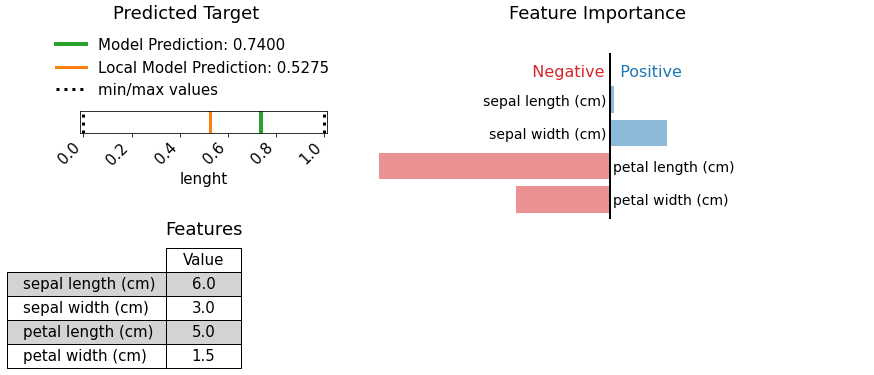

In [21]:
fig, axs = ExplainGraph.plot(explanation)
plt.savefig(f'iris_x_{x_explain}_lime.svg', dpi=300)

In [16]:
exp.show_in_notebook(show_table=True)

## MeLIME - KDEGen - Explantion

In [34]:
generator = KDEGen(verbose=True).fit(x_train)

Best Parameter for the KDE:
{'bandwidth': 0.18736842105263157}
Score: -47.940731956238395


In [23]:
explainer = Explainer(
    model_predict=rf.predict_proba,
    generator=generator, 
    local_model='Ridge', 
    feature_names=data.feature_names,
    target_names=data.target_names
)
explanation, counterfactual_examples = explainer.explain_instance(
    x_explain=x_explain.reshape(1, -1),
    class_index=1,
    r=1.0,
    n_samples=500,
    tol_importance=0.1,
    tol_error=0.1,
    local_mini_batch_max=40,
    scale_data=False,
    weight_kernel='gaussian'
)

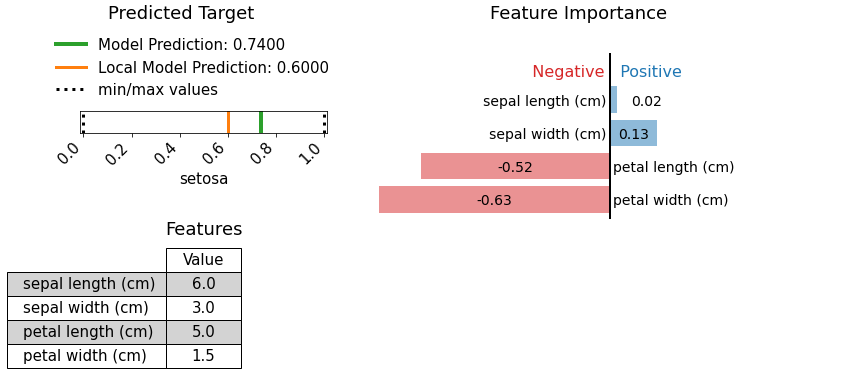

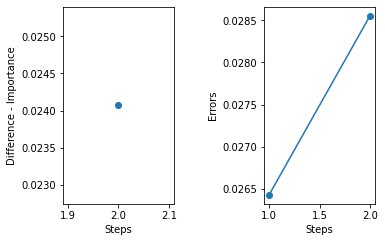

In [24]:
fig, axs = ExplainGraph.plot(explanation.explain())
plt.savefig(f'iris_x_{x_explain}_m-lime_kde.svg')
fig, axs = ExplainGraph.plot_errors(explanation)

## MeLIME - KDEPCAGen - Explantion

In [25]:
generator = KDEPCAGen(n_components=3).fit(x_train)

In [26]:
explainer = Explainer(
    model_predict=rf.predict_proba,
    generator=generator, 
    local_model='Ridge', 
    feature_names=data.feature_names
)
explanation, counterfactual_examples = explainer.explain_instance(
    x_explain=x_explain.reshape(1, -1),
    class_index=1,
    r=0.5,
    n_samples=500,
    tol_importance=0.1,
    tol_error=0.1,
    local_mini_batch_max=20,
    scale_data=False,
    weight_kernel='gaussian'
)

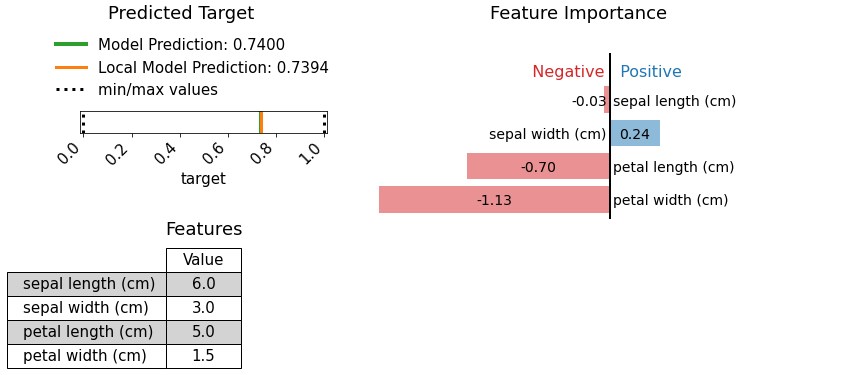

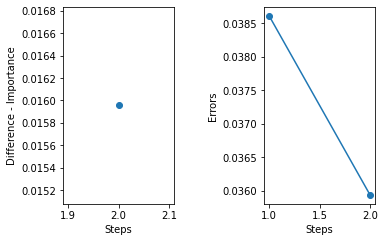

In [27]:
fig, axs = ExplainGraph.plot(explanation.explain())
plt.savefig(f'iris_x_{x_explain}_m-lime_pcakde.svg')
fig, axs = ExplainGraph.plot_errors(explanation)

### Tree Explanation

In [28]:
explainer = Explainer(
    model_predict=rf.predict_proba,
    generator=generator, 
    local_model='Tree', 
    feature_names=data.feature_names,
    target_names=data.target_names
)
explanation, counterfactual_examples = explainer.explain_instance(
    x_explain=x_explain.reshape(1, -1),
    class_index=1,
    r=1.0,
    n_samples=500,
    tol_importance=0.1,
    tol_error=0.1,
    local_mini_batch_max=40,
    scale_data=False,
    weight_kernel='gaussian'
)

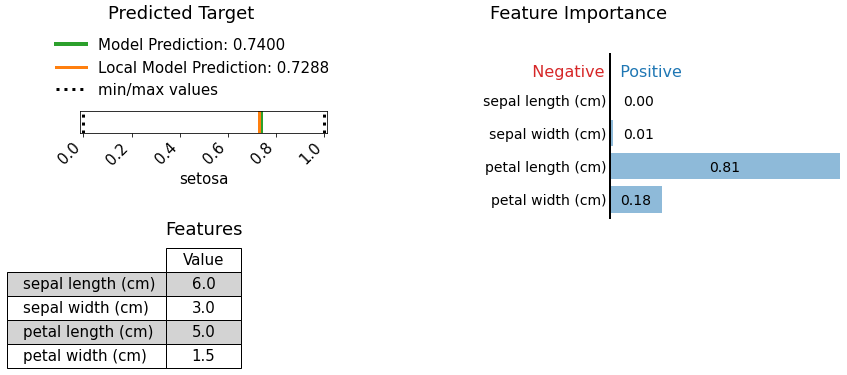

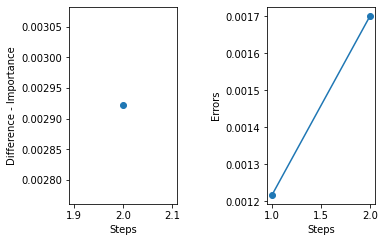

In [29]:
fig, axs = ExplainGraph.plot(explanation.explain())
plt.savefig(f'iris_x_{x_explain}_m-lime_kdepca_tree.svg')
fig, axs = ExplainGraph.plot_errors(explanation)

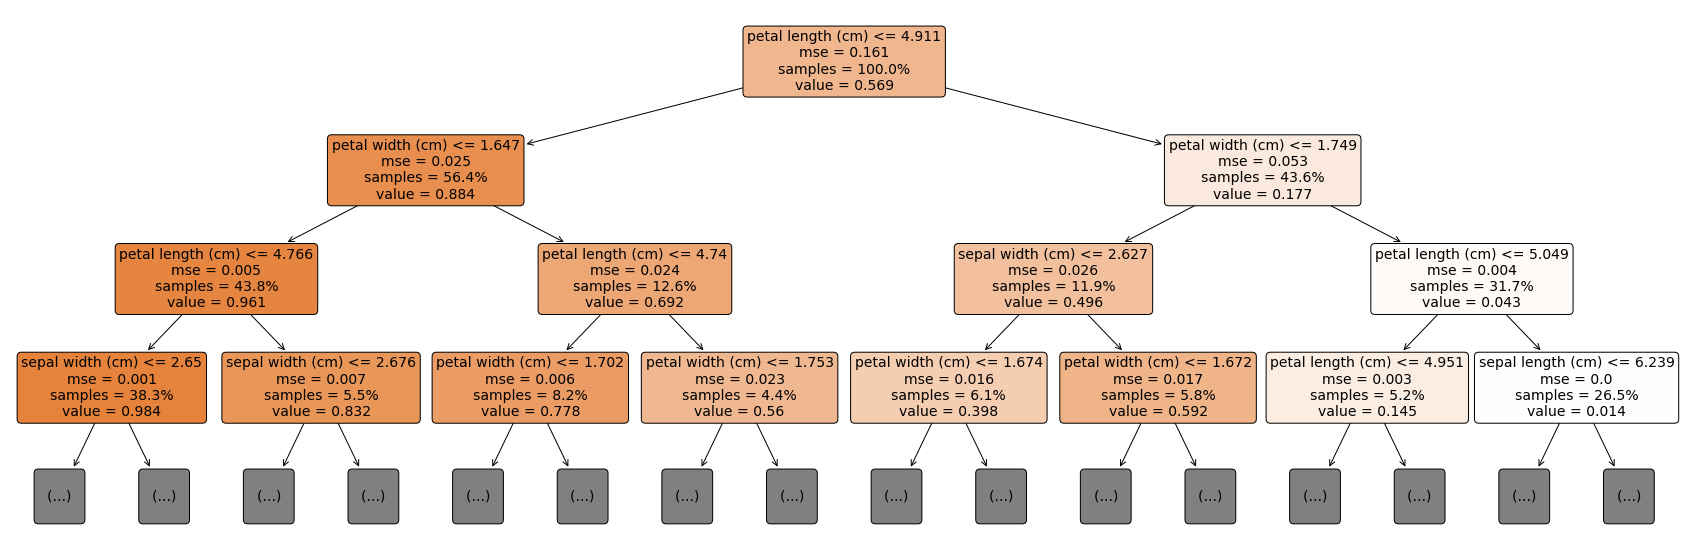

In [30]:
fig = plt.figure(figsize=(30, 10))
explanation.plot_tree()
plt.savefig(f'iris_x_{x_explain}_m-lime_kde_tree_plot.svg', dpi=300)

# Robustness of Explanation

Linear Local Model using KDEPCAGen generator 

Testing over random conditions

In [31]:
n_ = 1000
importances = np.zeros((n_,4))
for i in range(n_):
    explainer = Explainer(
    model_predict=rf.predict_proba,
    generator=generator, 
    local_model='Ridge', 
    feature_names=data.feature_names
    )
    explanation, counterfactual_examples = explainer.explain_instance(
    x_explain=x_explain.reshape(1, -1),
    class_index=1,
    r=0.5,
    n_samples=500,
    tol_importance=0.1,
    tol_error=0.1,
    local_mini_batch_max=200,
    scale_data=False,
    weight_kernel='gaussian'
    )
    importances[i] = explanation.importance


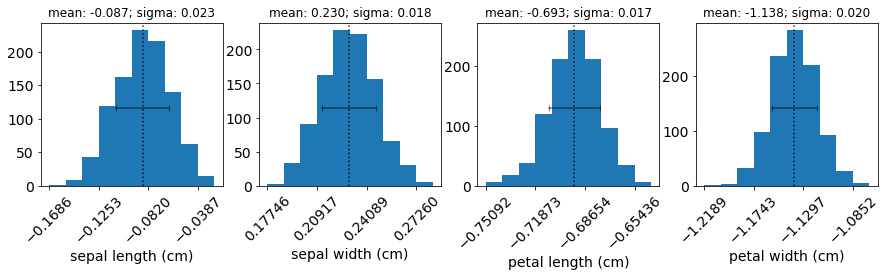

In [32]:
features_names = explanation.feature_names
fig, axis = plt.subplots(1,4, figsize=(15, 3))
for i, name in enumerate(features_names):
    mean = np.mean(importances[:, i])
    sigma = np.std(importances[:, i])
    axis[i].axvline(mean, c="black", linestyle=':', alpha=0.8)
    values, bins, patches = axis[i].hist(importances[:, i])
    means_y = np.max(values)/2
    axis[i].set_title(f'mean: {mean:5.3f}; sigma: {sigma:5.3f}')
    axis[i].plot(
        [mean-sigma, sigma+mean], [means_y, means_y], "|", c="black", linestyle='-', alpha=0.5)
    axis[i].set_xlabel(name, fontsize=14)
    axis[i].set_xticks(bins[::3])
    axis[i].tick_params(axis='x', labelsize=14)
    axis[i].tick_params(axis='y', labelsize=14)
    for tick in axis[i].get_xticklabels():
        tick.set_rotation(45)

Testing for small perturabations of $x_{explain}$

In [28]:
n_ = 500
importances = np.zeros((n_,4))
xs = np.zeros((n_,4))
for i in range(n_):
    explainer = Explainer(
    model_predict=rf.predict_proba,
    generator=generator, 
    local_model='Ridge', 
    feature_names=data.feature_names
    )
    error = np.random.rand(4)*0.1
    x_e = (x_explain[:]+error) 
    xs[i] = x_e[0]
    explanation, counterfactual_examples = explainer.explain_instance(
    x_explain=x_e.reshape(1, -1),
    class_index=1,
    r=0.5,
    n_samples=500,
    tol_importance=0.1,
    tol_error=0.1,
    local_mini_batch_max=200,
    scale_data=False,
    weight_kernel='gaussian'
    )
    importances[i] = explanation.importance

Plot Features

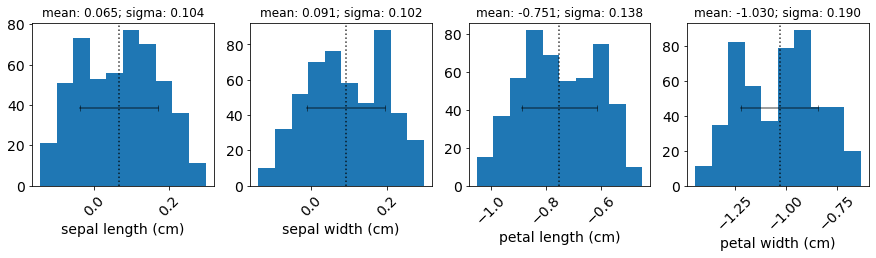

In [29]:
features_names = explanation.feature_names
fig, axis = plt.subplots(1,4, figsize=(15, 3))
for i, name in enumerate(features_names):
    mean = np.mean(importances[:, i])
    sigma = np.std(importances[:, i])
    axis[i].axvline(mean, c="black", linestyle=':', alpha=0.8)
    values, bins, patches = axis[i].hist(importances[:, i])
    means_y = np.max(values)/2
    axis[i].set_title(f'mean: {mean:5.3f}; sigma: {sigma:5.3f}')
    axis[i].plot(
        [mean-sigma, sigma+mean], [means_y, means_y], "|", c="black", linestyle='-', alpha=0.5)
    axis[i].set_xlabel(name, fontsize=14)
    axis[i].tick_params(axis='x', labelsize=14)
    axis[i].tick_params(axis='y', labelsize=14)
    for tick in axis[i].get_xticklabels():
        tick.set_rotation(45)
#     axis[i].set_xticks(bins[::3])

Plot instances

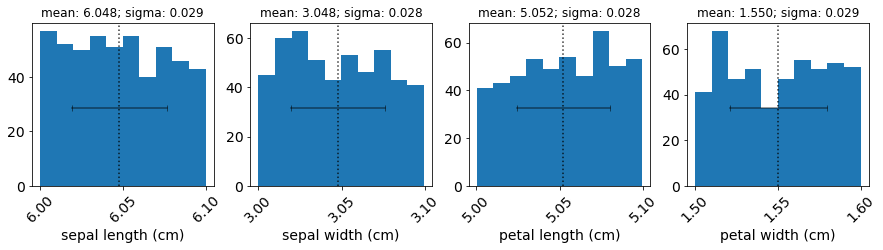

In [30]:
features_names = explanation.feature_names
fig, axis = plt.subplots(1,4, figsize=(15, 3))
for i, name in enumerate(features_names):
    mean = np.mean(xs[:, i])
    sigma = np.std(xs[:, i])
    axis[i].axvline(mean, c="black", linestyle=':', alpha=0.8)
    values, bins, patches = axis[i].hist(xs[:, i])
    means_y = np.max(values)/2
    axis[i].set_title(f'mean: {mean:5.3f}; sigma: {sigma:5.3f}')
    axis[i].plot(
        [mean-sigma, sigma+mean], [means_y, means_y], "|", c="black", linestyle='-', alpha=0.5)
    axis[i].set_xlabel(name, fontsize=14)
    axis[i].tick_params(axis='x', labelsize=14)
    axis[i].tick_params(axis='y', labelsize=14)
    for tick in axis[i].get_xticklabels():
        tick.set_rotation(45)

Thank you!